In [1]:
from xgboost import XGBClassifier
import xgboost as xgb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, PandasTools

import deepchem as dc

In [2]:
bbb_df = pd.read_csv('adenot_processed.csv')

## Optimized XGB

In [3]:
xg_best = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.85,
 reg_alpha=1e-05,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,)

## Scaffold Split

In [4]:
Xs = bbb_df.iloc[:,3:].copy()
Ys = bbb_df.iloc[:,2].copy()
dataset = dc.data.DiskDataset.from_numpy(X=Xs,y=Ys,ids=bbb_df['SMILES'].tolist())
scaffoldsplitter = dc.splits.ScaffoldSplitter()
train_scaff, test_scaff = scaffoldsplitter.train_test_split(dataset)

## Model Training and Predictions

In [5]:
# Train Decision Tree classifier
xg_best = xg_best.fit(train_scaff.X,train_scaff.y)

In [6]:
# Predict the response for test dataset
y_pred_scaff = xg_best.predict(test_scaff.X)

In [7]:
y_pred_scaff_prob = xg_best.predict_proba(test_scaff.X)

prob_test_df = pd.DataFrame()
prob_test_df['SMILES'] = test_scaff.ids
prob_test_df['Prob Permeable'] = y_pred_scaff_prob[:,1]
prob_test_df = prob_test_df.sort_values(by=['Prob Permeable'], ascending=False)
prob_test_df

,SMILES,Prob Permeable
151,CC1CCCCC1(N1CCCCC1)c1sccc1,0.999999
25,Clc1ccccc1C1=NCc2nnc(n2c2sc(cc12)Br)C1CCCCC1,0.999998
65,CN1CCC(CC1)=C1c2ccsc2CCc2ccccc12,0.999997
62,C1CN2CCC1C(C2)N1c2ccccc2CCc2ccccc12,0.999995
54,CCn1c2ccccc2c2c1C(C)(CCN(C)C)SCC2,0.999992
...,...,...
275,CC1(C)S[C@@H]2[C@H](NC(=O)C34CC5CC(CC(N)(C5)C3...,0.000121
204,CC[C@H](C(=O)NC/C=C/C=C(\C)/[C@@H](OC)[C@@H](C...,0.000119
246,CO\N=C(\C(=O)N[C@H]1[C@H]2SCC(=C(N2C1=O)C(O)=O...,0.000095
270,N[C@@H](C(=O)N[C@H]1[C@H]2SCC(=C(N2C1=O)C(O)=O...,0.000045


## Feature Importances

In [8]:
# get importance
dt_importance = xg_best.feature_importances_

# summarize and print out the feature importance
non_zero_index_list = [i for i, v in enumerate(dt_importance) if v != 0]

# remove all zero value entries
non_zero_feature_names = [bbb_df.iloc[:,3:].columns[i] for i in non_zero_index_list]
non_zero_importance = [dt_importance[i] for i in non_zero_index_list]
non_zero_feature_names_str = [str(x) for x in non_zero_feature_names]
feature_importance = pd.DataFrame(list(zip(non_zero_feature_names_str, non_zero_importance)), columns =['Feature','Importance'])
feature_importance.sort_values(by='Importance', ascending=True, inplace=True)

Text(0.5, 1.0, 'Top 10 XGBoost Feature Importances')

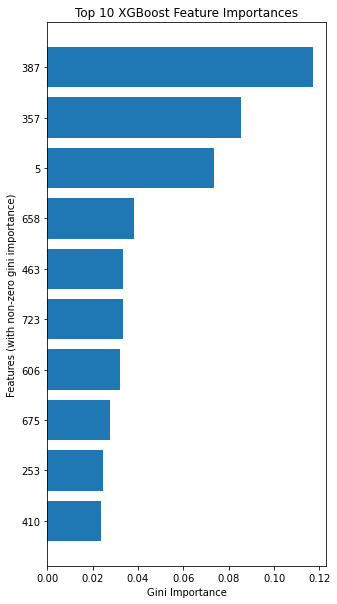

In [9]:
fig,ax = plt.subplots(figsize=(5,10))
plt.xlabel('Gini Importance')
plt.ylabel('Features (with non-zero gini importance)')
plt.barh(feature_importance['Feature'][-10:], feature_importance['Importance'][-10:])
plt.title('Top 10 XGBoost Feature Importances')

In [10]:
important_feature_list = np.array(feature_importance['Feature'].values).astype(int)
important_feature_list[-20:]

array([202, 125, 981, 936, 452, 464, 299, 272, 338, 212, 410, 253, 675,
       606, 723, 463, 658,   5, 357, 387])